### Parsing documents


PDFs:
- OCR and Text extractors:
    - Free solutions: PyPDF, pytessaract
    - Cloud providers: Amazon Textract, Microsoft FormRecognizer/DocumentAI, Google Doc AI

- Multimodal embeddings:
    - Open source: ColPali
    - Not OS: CLIP ("Open"AI)

- Text Summary of PDFs w Multimodal LLMs
    - Open source: LLaVa, Qwen2.5-VL, etc.
    - Not OS: GPT4o, Gemini, etc.



In [1]:
import torch
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from pdf2image import convert_from_path
from transformers.utils.import_utils import is_flash_attn_2_available

from colpali_engine.models import ColQwen2, ColQwen2Processor
import torch

/home/david-hajdu/Desktop/chatbot_modules/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda')

model_name = (
    "vidore/colqwen2-v0.1"  
)
colpali_model = ColQwen2.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  
    attn_implementation="flash_attention_2" if is_flash_attn_2_available() else None,
)
colpali_processor = ColQwen2Processor.from_pretrained(model_name)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


In [3]:
qdrant_client = QdrantClient(":memory:")
collection_name='dyson'

In [4]:
images = convert_from_path('/home/david-hajdu/Desktop/chatbot_modules/dyson.pdf')
vector_size = 128

images

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>]

In [5]:
qdrant_client.recreate_collection(
    collection_name='dyson',  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    ),
)

/tmp/ipykernel_33548/2982281712.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [6]:
def upsert_to_qdrant(points):
    try:
        qdrant_client.upsert(
            collection_name='dyson',
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [7]:
batch_size = 1 # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(images), desc="Indexing Progress") as pbar:
    for i in range(0, len(images), batch_size):
        batch = images[i : i + batch_size]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(batch).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

Indexing Progress: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


In [8]:
query_text = "charging your machine"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[-0.0728, -0.0164, -0.0099,  ...,  0.0303,  0.0028,  0.1064],
         [-0.1436, -0.0513,  0.1768,  ...,  0.1069,  0.0918, -0.0199],
         [-0.0310, -0.1216,  0.0649,  ...,  0.0825,  0.0147,  0.0112],
         ...,
         [-0.0820,  0.0144,  0.0378,  ...,  0.1357, -0.0884, -0.0874],
         [-0.0977,  0.0206,  0.0248,  ...,  0.1416, -0.0815, -0.0942],
         [-0.1089,  0.0386,  0.0198,  ...,  0.1328, -0.0957, -0.0869]]],
       device='cuda:0', dtype=torch.bfloat16)

In [9]:
query_embedding[0].shape

torch.Size([15, 128])

In [10]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [11]:
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

search_result.points

[ScoredPoint(id=4, version=0, score=12.244230340403961, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=0, version=0, score=11.87483627951996, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=7, version=0, score=11.254428692245318, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=1, version=0, score=10.407377824592505, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=11, version=0, score=10.316461963573502, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=12, version=0, score=10.294526118273774, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=14, version=0, score=9.893665914769157, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_valu

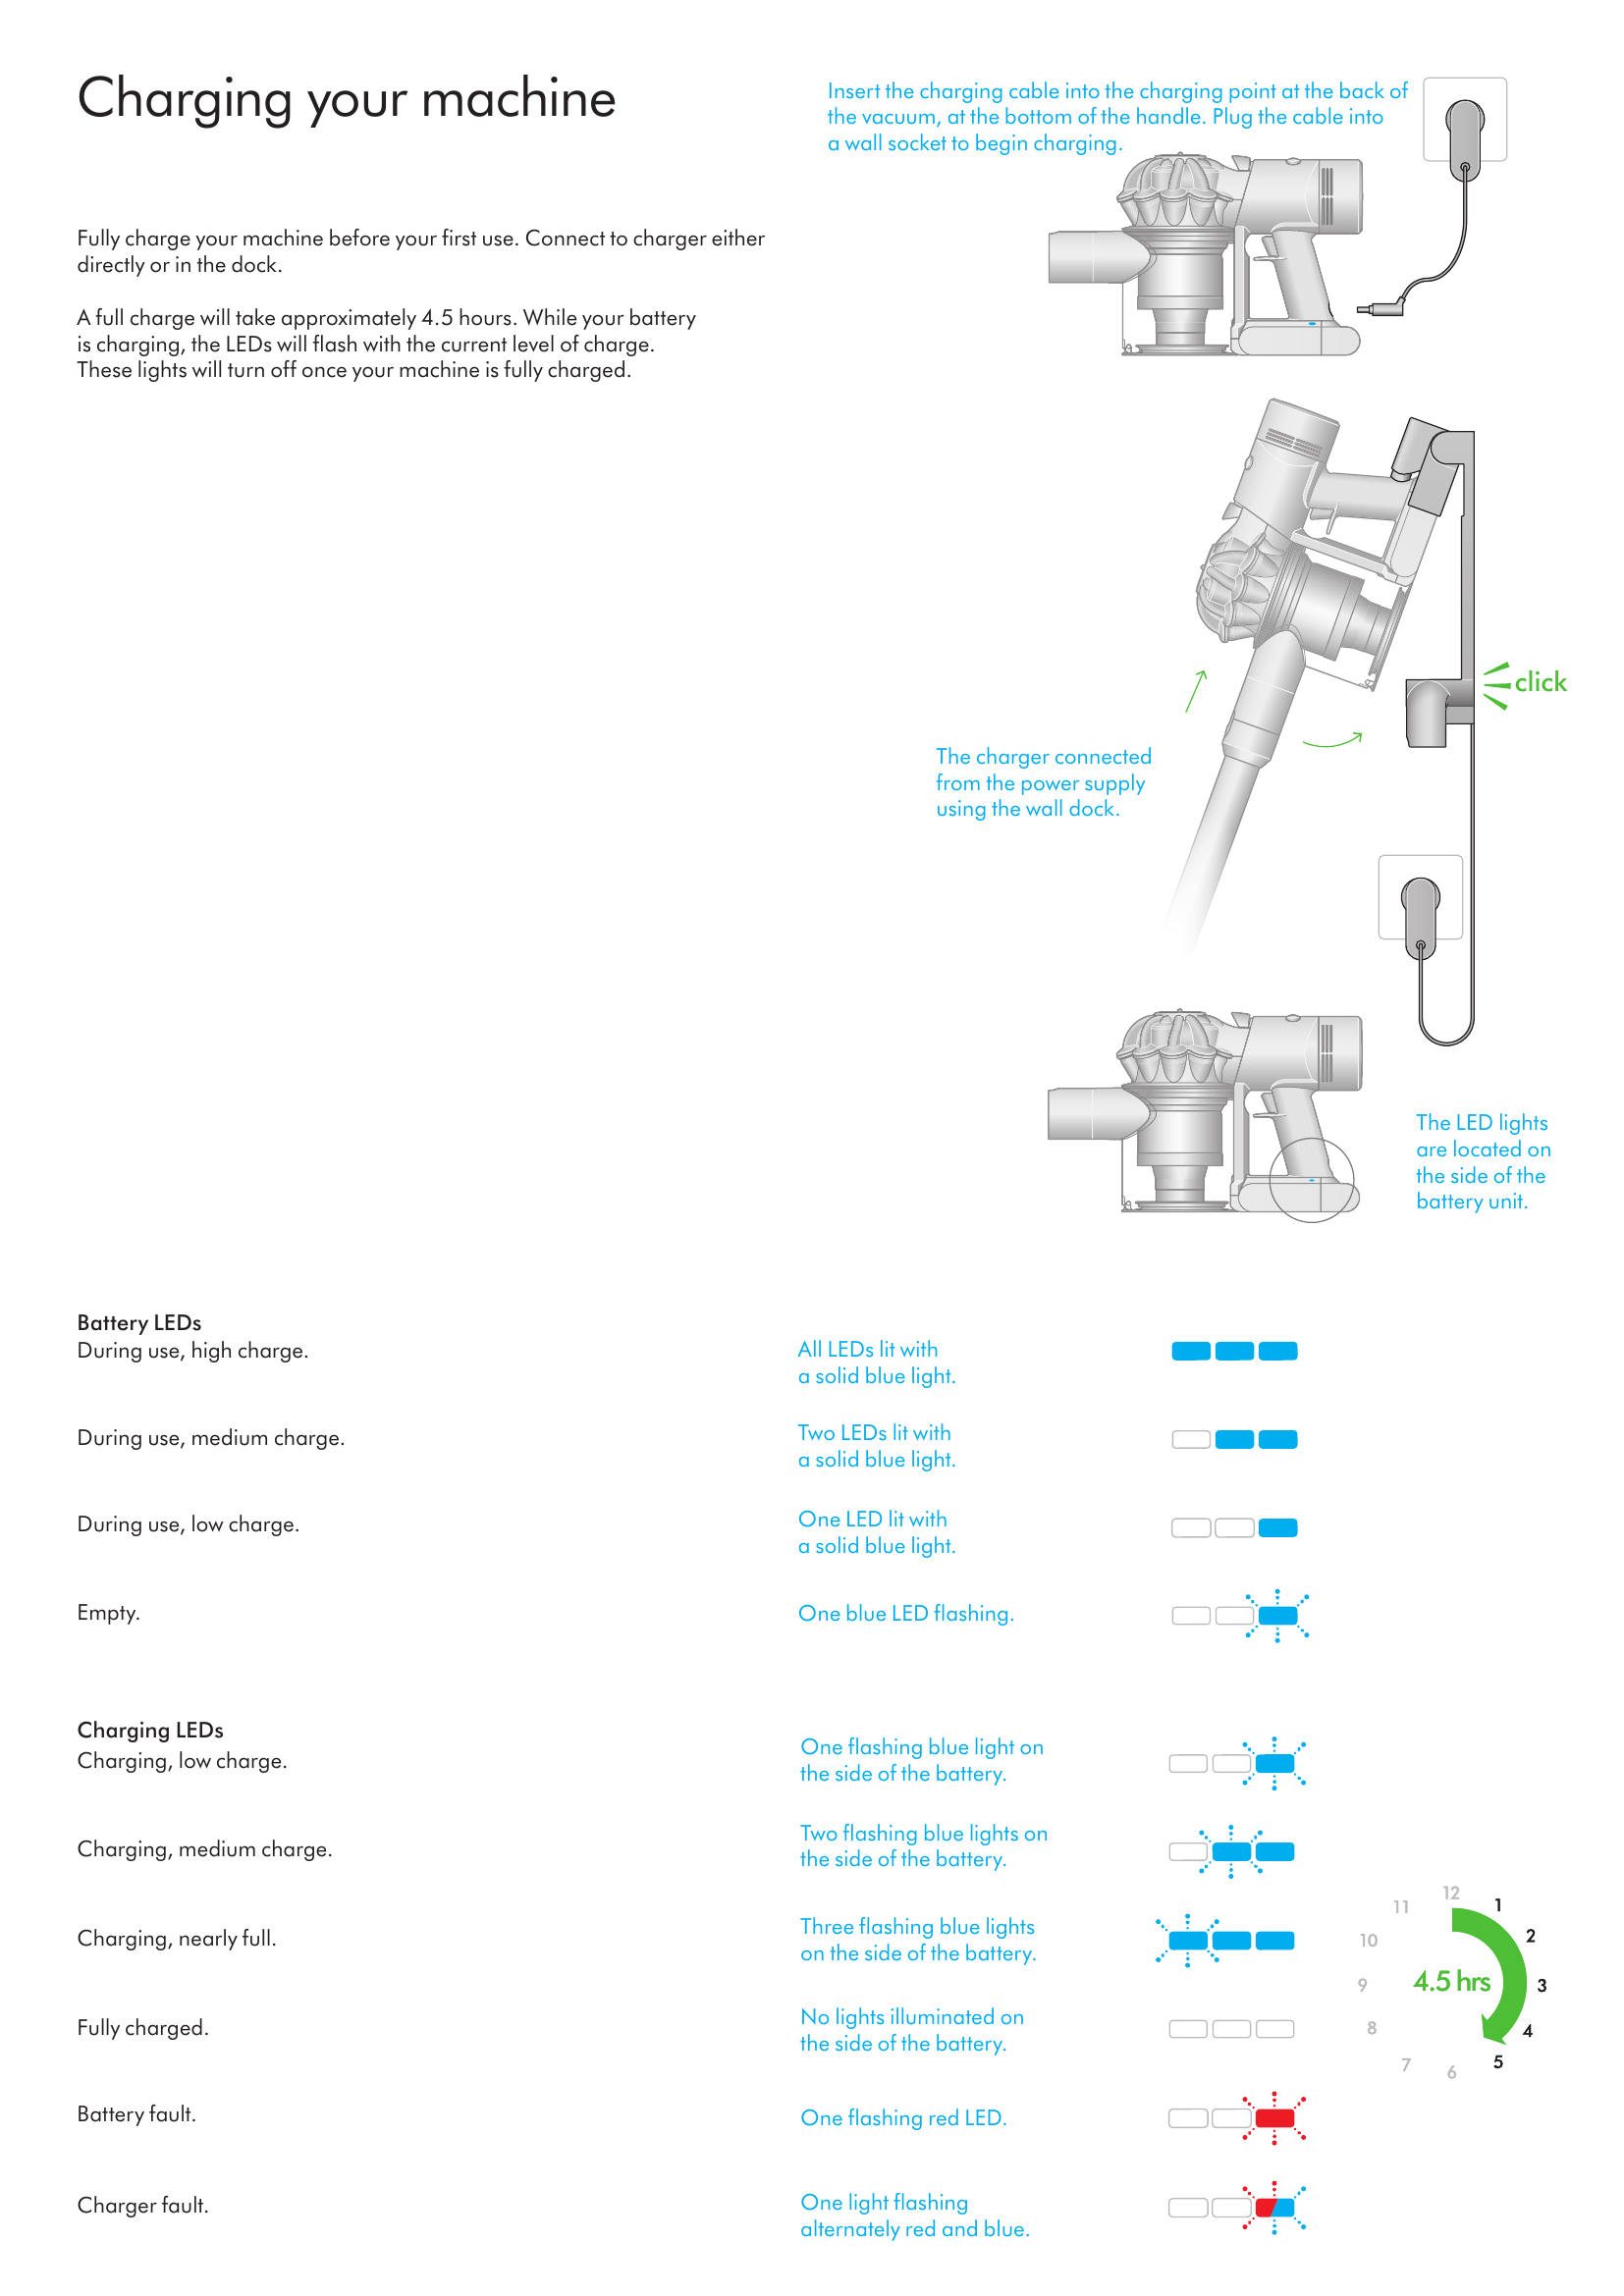

In [12]:
idx = search_result.points[0].id

images[idx]

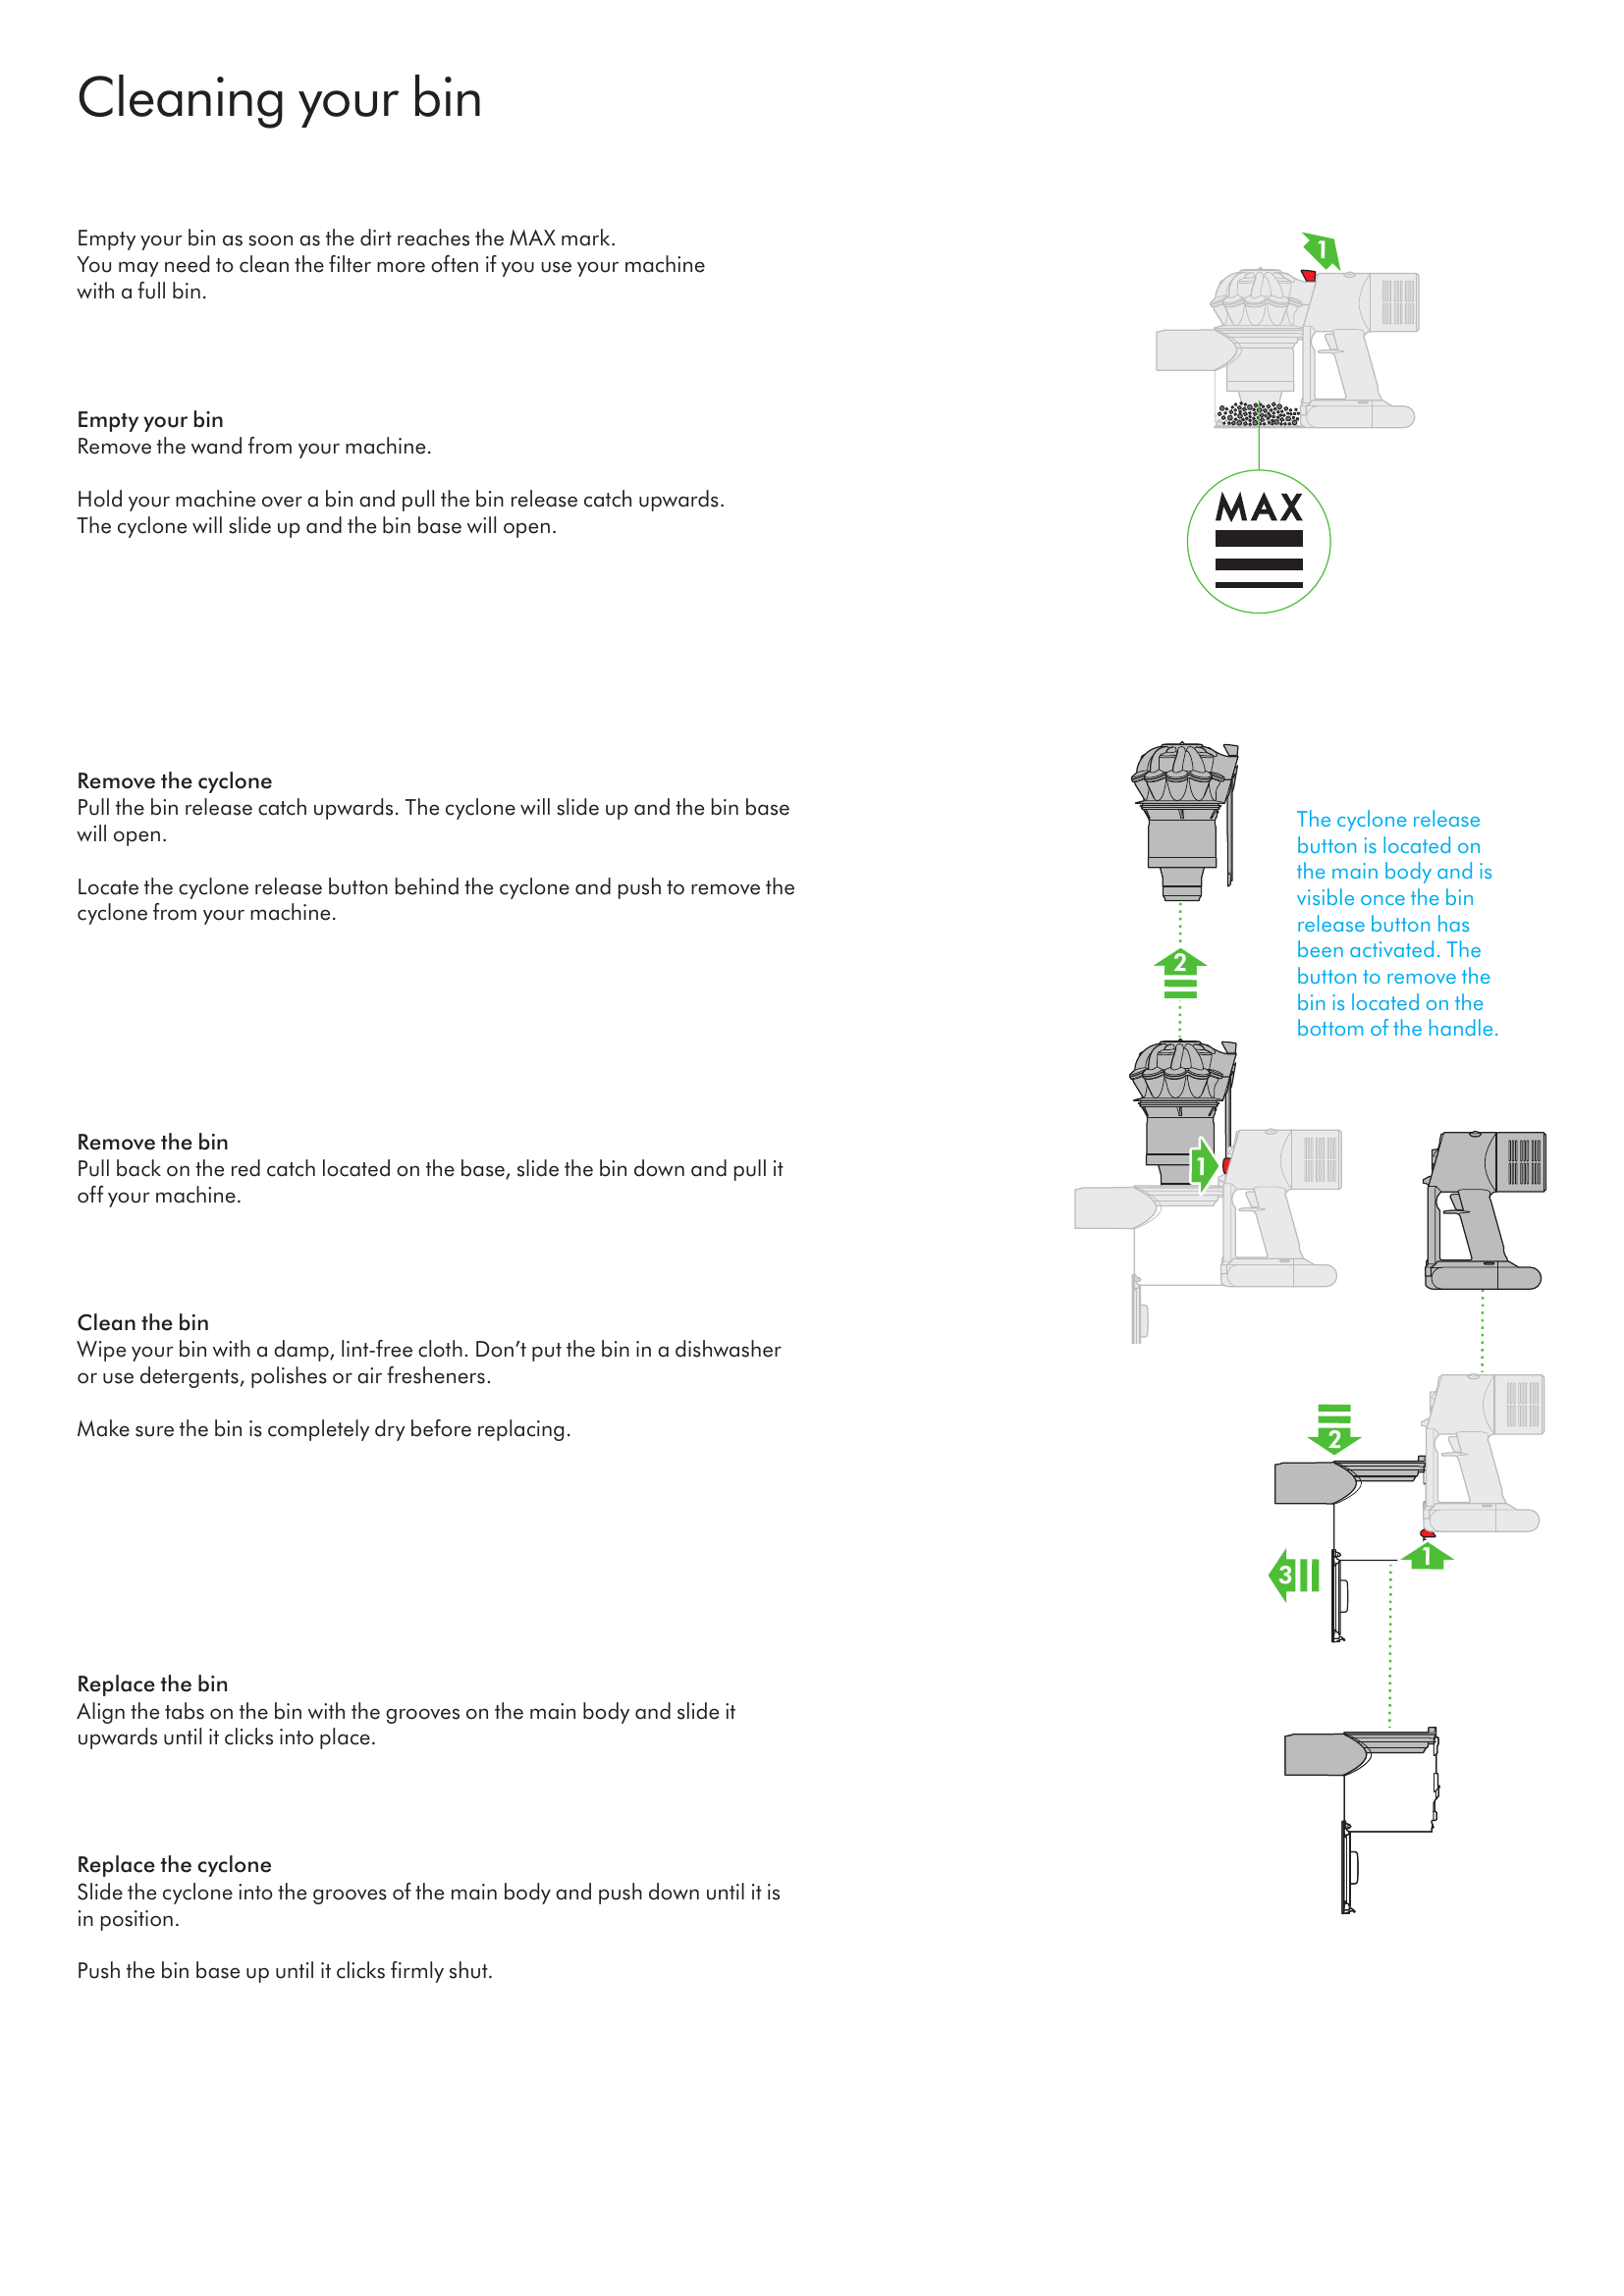

In [13]:
query_text = "How to empty the bin?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)

multivector_query = query_embedding[0].cpu().float().numpy().tolist()

search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

idx = search_result.points[0].id

images[idx]